<a href="https://colab.research.google.com/github/sarojkhanal-git/CBEAS_Whole_brain_and_Hippocampal_Segmentation/blob/main/Kfold1_NO_TUNING_Hippo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries Import

In [ ]:
import pandas as pd

In [ ]:
%pip install "monai==1.4.1rc1" -q
#%pip install torchinfo -q
#%pip install thop -q

In [ ]:
!pip install numpy==1.24.3

In [ ]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime


import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim


from monai.config import print_config
from monai.metrics import DiceMetric
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceLoss
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    Resize,
    ScaleIntensity,
    ToTensor,
    Lambda,
    EnsureType,
)
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference


from monai.metrics import compute_hausdorff_distance, SurfaceDistanceMetric
from monai.metrics import HausdorffDistanceMetric


#from torchinfo import summary
#from thop import profile


from google.colab import drive
print_config()

MONAI version: 1.4.1rc1
Numpy version: 1.24.3
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e604d1841fe60c0ffb6978ae4116535ca8d8f34f
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.2.1
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.51.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/e

##Drive Mount

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Image, Label and FreeSurferColorLUT Directory

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
image_dir = "MNI_train_data/image_files"
label_dir = "MNI_train_data/label_files_combined"

In [ ]:
lut_path = "FreeSurferColorLUT.txt"

##Image & Labels Extraction and Visualization

In [ ]:
images = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))

In [ ]:
len(images), len(labels)

(25, 25)

In [ ]:
def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  df = pd.read_csv(lut_path,sep='\s+', comment = '#', names = ['Label_ID', 'Label_Name', 'R', 'G', 'B', 'A'], usecols = ['Label_ID', 'Label_Name', 'R', 'G', 'B'])

  unique_labels = np.unique(label_image)

  rgb_img = np.zeros((*label_image.shape, 3), dtype = np.uint8)

  for labels in unique_labels:
     rgb_values = df.loc[df['Label_ID'] == labels, ['R', 'G', 'B']].values[0]
     rgb_img[label_image == labels] = rgb_values

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[slice_num,: ,:], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(rgb_img[slice_num, :, :, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[slice_num, :, :], cmap = 'gray')
  axs[2].imshow(rgb_img[slice_num, :, :, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()




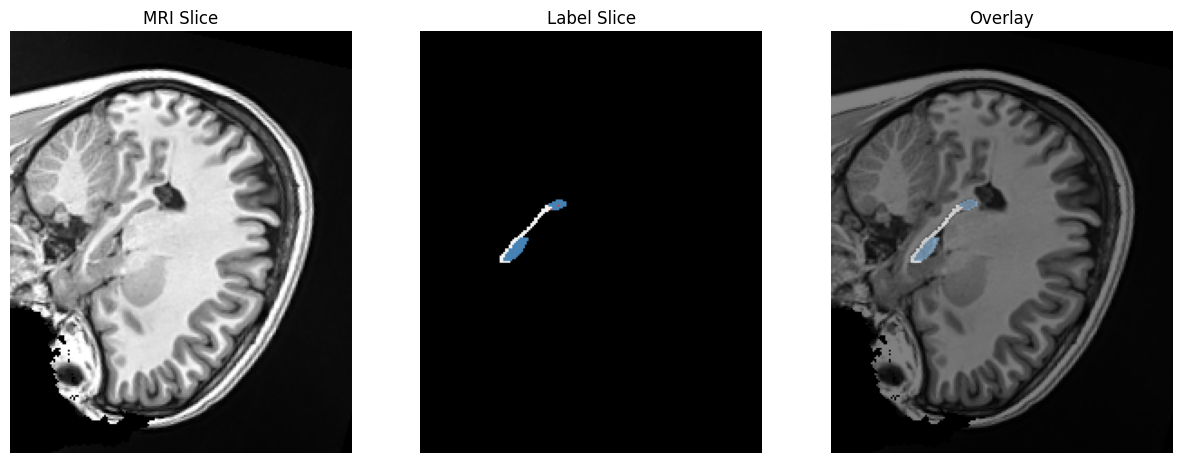

In [ ]:
visualize_image(images[0],labels[0], 75)

##Image Transforms and Custom Dataset

####Transforms

In [ ]:
from monai.transforms import SpatialCrop, CenterSpatialCrop

In [ ]:
img_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    ScaleIntensity(),
    EnsureChannelFirst(),
    #SpatialCrop(roi_center= (98, 122, 55), roi_size=(128, 128, 128)) #(197, 189, 233)
    CenterSpatialCrop(roi_size=(160, 160, 160))
])

seg_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    EnsureChannelFirst(),
    #SpatialCrop(roi_center= (98, 122, 55), roi_size=(128, 128, 128)) #(197, 189, 233)
    CenterSpatialCrop(roi_size=(160, 160, 160))
])


In [ ]:
class MyBrainDataset(Dataset):
    def __init__(self, data, img_tfms, seg_tfms):
        super().__init__(data)
        self.img_tfms = img_tfms
        self.seg_tfms = seg_tfms

    def __getitem__(self, idx):
        d = self.data[idx]
        image = self.img_tfms(d["image"])
        label = self.seg_tfms(d["label"])
        return image, label


##Dataset Loading

In [ ]:
data_dicts = [{"image": i, "label": s} for i, s in zip(images, labels)]

#Training on 1st fold
train_files = data_dicts[5:]
val_files   = data_dicts[:5]
print(f"Train Files: {train_files[0]}/n/n")
print(f"Val Files: {val_files[0]}")

print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")


Train Files: {'image': 'MNI_train_data/image_files/s06_t1w_standard_defaced_MNI.nii.gz', 'label': 'MNI_train_data/label_files_combined/s06_hippolabels_t1w_standard_L_MNI.nii.gz'}/n/n
Val Files: {'image': 'MNI_train_data/image_files/s01_t1w_standard_defaced_MNI.nii.gz', 'label': 'MNI_train_data/label_files_combined/s01_hippolabels_t1w_standard_L_MNI.nii.gz'}
Number of training samples: 20
Number of validation samples: 5


In [ ]:
train_ds = MyBrainDataset(train_files, img_transforms, seg_transforms)
val_ds   = MyBrainDataset(val_files,   img_transforms, seg_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2)

In [ ]:
imgt, segt = train_ds[0]
imgt = imgt.squeeze().numpy()
segt = segt.squeeze().numpy()
imgt.shape, segt.shape

((160, 160, 160), (160, 160, 160))

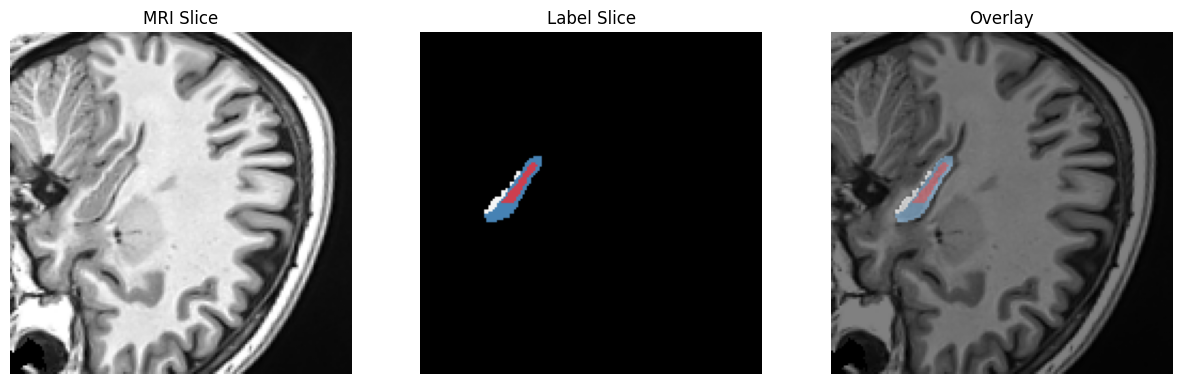

In [ ]:
visualize_image(imgt, segt, 50, array = True)

##Model, Optimizer and Loss Function

In [ ]:
from monai.losses import DiceCELoss

In [ ]:
set_determinism(seed=40)

num_classes = 4

model = SwinUNETR(
    img_size=(160, 160, 160),
    in_channels=1,
    out_channels=num_classes,
    feature_size=24,
    use_checkpoint=True

).cuda()


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


##Loading Pre-Trained Model

In [ ]:
len(model.state_dict())

159

#Adapter Layer

##Model Details

In [ ]:

loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=0.7, lambda_ce=0.3, include_background=True)

trainable_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 50, 70], gamma=0.1)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

hd95_metric = HausdorffDistanceMetric(include_background=False, percentile=95.0, reduction="mean")
asd_metric = SurfaceDistanceMetric(include_background=False, reduction="mean")

post_trans = Compose([
    Activations(softmax=True),
    AsDiscrete(argmax=True, to_onehot=num_classes)
])

to_onehot = AsDiscrete(to_onehot=num_classes)


In [ ]:
#summary(model, input_size=(1, 1, 128, 128, 128))

In [ ]:
'''
input_tensor = torch.randn(1, 1, 128, 128, 128)
flops, params = profile(model, inputs=(input_tensor,))
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")
'''

'\ninput_tensor = torch.randn(1, 1, 128, 128, 128)\nflops, params = profile(model, inputs=(input_tensor,))\nprint(f"FLOPs: {flops}")\nprint(f"Parameters: {params}")\n'

##Functions to load and save model and checkpoints

In [ ]:
def save_best_model(model, best_model_path):
    torch.save(model.state_dict(), best_model_path)

In [ ]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, hd95_list, asd_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path):
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'dice_mean': dice_mean,
    'epoch_list' : epoch_list,
    'val_dice_list' : val_dice_list,
    'train_loss_list' : train_loss_list,
    'hd95_list': hd95_list,
    'asd_list': asd_list,
    'best_metric': best_metric,
    'best_metric_epoch': best_metric_epoch,
    }
    torch.save(checkpoint, checkpoint_path)


In [ ]:
def load_checkpoint(path):
    checkpoint = torch.load(path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    dice_mean = checkpoint['dice_mean']
    epoch_list = checkpoint['epoch_list']
    val_dice_list = checkpoint['val_dice_list']
    hd95_list = checkpoint['hd95_list']
    asd_list = checkpoint['asd_list']
    train_loss_list = checkpoint['train_loss_list']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    return epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, hd95_list, asd_list, train_loss_list, best_metric, best_metric_epoch

##Load Checkpoint

In [ ]:
#epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, hd95_list, asd_list, train_loss_list, best_metric, best_metric_epoch = load_checkpoint('adapter1_res_Checkpoint.pth')

##Epochs and Validation

In [ ]:
max_epochs = 80
val_interval = 1

###Run if Checkpoints are not loaded

In [ ]:
train_loss_list = []
val_dice_list   = []
epoch_list      = []
hd95_list = []
asd_list  = []
epoch=0
dice_mean = -1
best_metric = -1
best_metric_epoch = -1

##Train and Validation Loop

In [ ]:
from tqdm import tqdm

In [ ]:
start_epoch=epoch

In [ ]:
import torch.nn.functional as F

In [ ]:
checkpoint_path = 'Train_Data_INFO/Cross_Validation/Fold1_NoTuning_Checkpoint.pth'
best_model_path = 'Train_Data_INFO/Cross_Validation/Fold1_NoTuning_best_dice_model.pth'

#Training Loop
for epoch in range(max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}] {datetime.datetime.now()}")
    model.train()
    epoch_loss = 0

    for batch_data in tqdm(train_loader, leave=False):
        inputs, label = batch_data[0].cuda(), batch_data[1].cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    #scheduler.step()
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")



    # Validation Loop
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            for val_data in tqdm(val_loader, leave=False):
                val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)

                val_labels_onehot = [to_onehot(i) for i in decollate_batch(val_labels)]

                hd95_metric(y_pred=val_outputs, y=val_labels_onehot)
                asd_metric(y_pred=val_outputs, y=val_labels_onehot)


        dice_mean = dice_metric.aggregate().item()
        dice_metric.reset()


        hd95_mean = hd95_metric.aggregate().item()
        asd_mean  = asd_metric.aggregate().item()
        hd95_metric.reset()
        asd_metric.reset()

        hd95_list.append(hd95_mean)
        asd_list.append(asd_mean)

        val_dice_list.append(dice_mean)
        epoch_list.append(epoch + 1)
        print(f"  Validation Dice: {dice_mean:.4f}")
        print(f"  Validation HD95 : {hd95_mean:.4f} mm")
        print(f"  Validation ASD  : {asd_mean:.4f} mm")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_HD95 = hd95_mean
            best_ASD  = asd_mean
            best_metric_epoch = epoch + 1
            save_best_model(model, best_model_path)
            print("   Saved new best model")


    if (epoch + 1) % 20 == 0:
      checkpoint_path = f'Train_Data_INFO/Cross_Validation/Fold1_NoTuning_Checkpoint_{epoch}.pth'
    save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, hd95_list, asd_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path)
print(f"\nTraining complete. Best val Dice: {best_metric:.4f}, HD95: {best_HD95}, ASD: {best_ASD} at epoch {best_metric_epoch}")

Epoch [1/80] 2025-05-24 17:02:01.462142


  Train loss: 0.9195


 20%|██        | 1/5 [00:03<00:14,  3.65s/it]/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:335: UserWarning: the prediction of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
 60%|██████    | 3/5 [00:09<00:06,  3.16s/it]/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:335: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


  Validation Dice: 0.2457
  Validation HD95 : 96.5930 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [2/80] 2025-05-24 17:02:56.369157


  Train loss: 0.7713


  Validation Dice: 0.2496
  Validation HD95 : 91.3547 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [3/80] 2025-05-24 17:03:47.762366


  Train loss: 0.7144


  Validation Dice: 0.2497
  Validation HD95 : 85.5784 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [4/80] 2025-05-24 17:04:35.757495


  Train loss: 0.6704


  Validation Dice: 0.2497
  Validation HD95 : 103.3147 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [5/80] 2025-05-24 17:05:21.193608


  Train loss: 0.6351


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:335: UserWarning: the prediction of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(


  Validation Dice: 0.2497
  Validation HD95 : 0.0000 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [6/80] 2025-05-24 17:06:05.900787


  Train loss: 0.6074


  Validation Dice: 0.2535
  Validation HD95 : 48.1515 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [7/80] 2025-05-24 17:06:50.772372


  Train loss: 0.5840


  Validation Dice: 0.3445
  Validation HD95 : 11.4651 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [8/80] 2025-05-24 17:07:36.083158


  Train loss: 0.5634


  Validation Dice: 0.3655
  Validation HD95 : 5.5564 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [9/80] 2025-05-24 17:08:21.120567


  Train loss: 0.5474


  Validation Dice: 0.3592
  Validation HD95 : 6.4053 mm
  Validation ASD  : inf mm
Epoch [10/80] 2025-05-24 17:09:06.014393


  Train loss: 0.5324


  Validation Dice: 0.4117
  Validation HD95 : 5.6658 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [11/80] 2025-05-24 17:09:51.235528


  Train loss: 0.5098


  Validation Dice: 0.4923
  Validation HD95 : 5.8000 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [12/80] 2025-05-24 17:10:36.489543


  Train loss: 0.4847


  Validation Dice: 0.5245
  Validation HD95 : 5.1631 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [13/80] 2025-05-24 17:11:21.807963


  Train loss: 0.4605


  Validation Dice: 0.5436
  Validation HD95 : 3.4796 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [14/80] 2025-05-24 17:12:07.158091


  Train loss: 0.4282


  Validation Dice: 0.5616
  Validation HD95 : 3.0988 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [15/80] 2025-05-24 17:12:52.411802


  Train loss: 0.3939


  Validation Dice: 0.5634
  Validation HD95 : 3.2042 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [16/80] 2025-05-24 17:13:38.926676


  Train loss: 0.3569


  Validation Dice: 0.5868
  Validation HD95 : 2.7087 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [17/80] 2025-05-24 17:14:25.015097


  Train loss: 0.3301


  Validation Dice: 0.5859
  Validation HD95 : 2.9193 mm
  Validation ASD  : inf mm
Epoch [18/80] 2025-05-24 17:15:10.114292


  Train loss: 0.3162


  Validation Dice: 0.5802
  Validation HD95 : 2.7349 mm
  Validation ASD  : inf mm
Epoch [19/80] 2025-05-24 17:15:55.102177


  Train loss: 0.3022


  Validation Dice: 0.5931
  Validation HD95 : 2.5805 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [20/80] 2025-05-24 17:16:40.341316


  Train loss: 0.2890


  Validation Dice: 0.6026
  Validation HD95 : 2.5559 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [21/80] 2025-05-24 17:17:25.604761


  Train loss: 0.2813


  Validation Dice: 0.6142
  Validation HD95 : 2.4112 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [22/80] 2025-05-24 17:18:10.859611


  Train loss: 0.2743


  Validation Dice: 0.6141
  Validation HD95 : 2.4876 mm
  Validation ASD  : inf mm
Epoch [23/80] 2025-05-24 17:18:55.982322


  Train loss: 0.2722


  Validation Dice: 0.6142
  Validation HD95 : 2.3308 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [24/80] 2025-05-24 17:19:41.238905


  Train loss: 0.2690


  Validation Dice: 0.6099
  Validation HD95 : 2.5569 mm
  Validation ASD  : inf mm
Epoch [25/80] 2025-05-24 17:20:26.384816


  Train loss: 0.2659


  Validation Dice: 0.6206
  Validation HD95 : 2.2650 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [26/80] 2025-05-24 17:21:12.268702


  Train loss: 0.2644


  Validation Dice: 0.6219
  Validation HD95 : 2.1590 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [27/80] 2025-05-24 17:21:58.460182


  Train loss: 0.2612


  Validation Dice: 0.6029
  Validation HD95 : 21.5991 mm
  Validation ASD  : inf mm
Epoch [28/80] 2025-05-24 17:22:44.917960


  Train loss: 0.2603


  Validation Dice: 0.6244
  Validation HD95 : 2.1354 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [29/80] 2025-05-24 17:23:30.248436


  Train loss: 0.2572


  Validation Dice: 0.6263
  Validation HD95 : 2.2017 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [30/80] 2025-05-24 17:24:15.691457


  Train loss: 0.2580


  Validation Dice: 0.6191
  Validation HD95 : 2.2921 mm
  Validation ASD  : inf mm
Epoch [31/80] 2025-05-24 17:25:00.768399


  Train loss: 0.2591


  Validation Dice: 0.6238
  Validation HD95 : 2.1803 mm
  Validation ASD  : inf mm
Epoch [32/80] 2025-05-24 17:25:45.878625


  Train loss: 0.2540


  Validation Dice: 0.6320
  Validation HD95 : 1.9911 mm
  Validation ASD  : inf mm
   Saved new best model
Epoch [33/80] 2025-05-24 17:26:31.129235


  Train loss: 0.2525


  Validation Dice: 0.6301
  Validation HD95 : 1.9160 mm
  Validation ASD  : inf mm
Epoch [34/80] 2025-05-24 17:27:16.197852


  Train loss: 0.2495


  Validation Dice: 0.6513
  Validation HD95 : 4.6912 mm
  Validation ASD  : 1.1294 mm
   Saved new best model
Epoch [35/80] 2025-05-24 17:28:01.769242


  Train loss: 0.2435


  Validation Dice: 0.7379
  Validation HD95 : 4.3600 mm
  Validation ASD  : 0.9651 mm
   Saved new best model
Epoch [36/80] 2025-05-24 17:28:47.253484


  Train loss: 0.2229


  Validation Dice: 0.7766
  Validation HD95 : 2.7911 mm
  Validation ASD  : 0.8007 mm
   Saved new best model
Epoch [37/80] 2025-05-24 17:29:32.644958


  Train loss: 0.1971


  Validation Dice: 0.7723
  Validation HD95 : 4.2313 mm
  Validation ASD  : 1.0659 mm
Epoch [38/80] 2025-05-24 17:30:18.743131


  Train loss: 0.1711


  Validation Dice: 0.8297
  Validation HD95 : 1.9856 mm
  Validation ASD  : 0.6019 mm
   Saved new best model
Epoch [39/80] 2025-05-24 17:31:04.751610


  Train loss: 0.1450


  Validation Dice: 0.8218
  Validation HD95 : 1.8171 mm
  Validation ASD  : 0.5864 mm
Epoch [40/80] 2025-05-24 17:31:49.935803


  Train loss: 0.1340


  Validation Dice: 0.8363
  Validation HD95 : 1.6736 mm
  Validation ASD  : 0.4807 mm
   Saved new best model
Epoch [41/80] 2025-05-24 17:32:35.344215


  Train loss: 0.1220


  Validation Dice: 0.8274
  Validation HD95 : 1.7741 mm
  Validation ASD  : 0.4758 mm
Epoch [42/80] 2025-05-24 17:33:20.446945


  Train loss: 0.1169


  Validation Dice: 0.8138
  Validation HD95 : 2.2134 mm
  Validation ASD  : 0.4249 mm
Epoch [43/80] 2025-05-24 17:34:05.579852


  Train loss: 0.1125


  Validation Dice: 0.8394
  Validation HD95 : 1.8198 mm
  Validation ASD  : 0.5293 mm
   Saved new best model
Epoch [44/80] 2025-05-24 17:34:51.038030


  Train loss: 0.1069


  Validation Dice: 0.8351
  Validation HD95 : 1.8380 mm
  Validation ASD  : 0.4164 mm
Epoch [45/80] 2025-05-24 17:35:36.158961


  Train loss: 0.1019


  Validation Dice: 0.8312
  Validation HD95 : 1.8078 mm
  Validation ASD  : 0.4786 mm
Epoch [46/80] 2025-05-24 17:36:21.268004


  Train loss: 0.1128


  Validation Dice: 0.7887
  Validation HD95 : 2.5104 mm
  Validation ASD  : 0.5916 mm
Epoch [47/80] 2025-05-24 17:37:06.431494


  Train loss: 0.1127


  Validation Dice: 0.8303
  Validation HD95 : 1.8364 mm
  Validation ASD  : 0.5032 mm
Epoch [48/80] 2025-05-24 17:37:52.174093


  Train loss: 0.1016


  Validation Dice: 0.8406
  Validation HD95 : 1.7188 mm
  Validation ASD  : 0.4169 mm
   Saved new best model
Epoch [49/80] 2025-05-24 17:38:37.607013


  Train loss: 0.0946


  Validation Dice: 0.8475
  Validation HD95 : 1.6774 mm
  Validation ASD  : 0.4275 mm
   Saved new best model
Epoch [50/80] 2025-05-24 17:39:23.005444


  Train loss: 0.0933


  Validation Dice: 0.8358
  Validation HD95 : 1.9235 mm
  Validation ASD  : 0.4272 mm
Epoch [51/80] 2025-05-24 17:40:08.171376


  Train loss: 0.0913


  Validation Dice: 0.8381
  Validation HD95 : 1.7996 mm
  Validation ASD  : 0.4477 mm
Epoch [52/80] 2025-05-24 17:40:53.444987


  Train loss: 0.0911


  Validation Dice: 0.8490
  Validation HD95 : 1.8400 mm
  Validation ASD  : 0.4219 mm
   Saved new best model
Epoch [53/80] 2025-05-24 17:41:38.839720


  Train loss: 0.0902


  Validation Dice: 0.8466
  Validation HD95 : 1.6514 mm
  Validation ASD  : 0.4858 mm
Epoch [54/80] 2025-05-24 17:42:24.338937


  Train loss: 0.0926


  Validation Dice: 0.8497
  Validation HD95 : 1.6291 mm
  Validation ASD  : 0.4781 mm
   Saved new best model
Epoch [55/80] 2025-05-24 17:43:09.945492


  Train loss: 0.0913


  Validation Dice: 0.8406
  Validation HD95 : 1.8122 mm
  Validation ASD  : 0.4271 mm
Epoch [56/80] 2025-05-24 17:43:55.263375


  Train loss: 0.0855


  Validation Dice: 0.8461
  Validation HD95 : 1.6503 mm
  Validation ASD  : 0.4333 mm
Epoch [57/80] 2025-05-24 17:44:40.984841


  Train loss: 0.0856


  Validation Dice: 0.8396
  Validation HD95 : 1.8071 mm
  Validation ASD  : 0.4256 mm
Epoch [58/80] 2025-05-24 17:45:26.234699


  Train loss: 0.0837


  Validation Dice: 0.8503
  Validation HD95 : 1.7555 mm
  Validation ASD  : 0.4441 mm
   Saved new best model
Epoch [59/80] 2025-05-24 17:46:11.799707


  Train loss: 0.0822


  Validation Dice: 0.8456
  Validation HD95 : 1.7338 mm
  Validation ASD  : 0.4423 mm
Epoch [60/80] 2025-05-24 17:46:57.152030


  Train loss: 0.0800


  Validation Dice: 0.8494
  Validation HD95 : 1.6093 mm
  Validation ASD  : 0.4153 mm
Epoch [61/80] 2025-05-24 17:47:42.373397


  Train loss: 0.0806


  Validation Dice: 0.8531
  Validation HD95 : 1.6949 mm
  Validation ASD  : 0.4407 mm
   Saved new best model
Epoch [62/80] 2025-05-24 17:48:27.740678


  Train loss: 0.0780


  Validation Dice: 0.8510
  Validation HD95 : 1.6363 mm
  Validation ASD  : 0.4219 mm
Epoch [63/80] 2025-05-24 17:49:13.010279


  Train loss: 0.0784


  Validation Dice: 0.8532
  Validation HD95 : 1.6499 mm
  Validation ASD  : 0.4215 mm
   Saved new best model
Epoch [64/80] 2025-05-24 17:49:58.408748


  Train loss: 0.0769


  Validation Dice: 0.8525
  Validation HD95 : 1.5674 mm
  Validation ASD  : 0.4287 mm
Epoch [65/80] 2025-05-24 17:50:44.567378


  Train loss: 0.0743


  Validation Dice: 0.8575
  Validation HD95 : 1.6224 mm
  Validation ASD  : 0.4343 mm
   Saved new best model
Epoch [66/80] 2025-05-24 17:51:30.368126


  Train loss: 0.0721


  Validation Dice: 0.8492
  Validation HD95 : 1.6759 mm
  Validation ASD  : 0.4201 mm
Epoch [67/80] 2025-05-24 17:52:15.646862


  Train loss: 0.0707


  Validation Dice: 0.8512
  Validation HD95 : 1.6417 mm
  Validation ASD  : 0.4065 mm
Epoch [68/80] 2025-05-24 17:53:00.882472


  Train loss: 0.0727


  Validation Dice: 0.8469
  Validation HD95 : 1.6829 mm
  Validation ASD  : 0.3988 mm
Epoch [69/80] 2025-05-24 17:53:46.057582


  Train loss: 0.0711


  Validation Dice: 0.8543
  Validation HD95 : 1.5499 mm
  Validation ASD  : 0.4262 mm
Epoch [70/80] 2025-05-24 17:54:31.474935


  Train loss: 0.0673


  Validation Dice: 0.8473
  Validation HD95 : 1.6958 mm
  Validation ASD  : 0.4201 mm
Epoch [71/80] 2025-05-24 17:55:16.764244


  Train loss: 0.0677


  Validation Dice: 0.8570
  Validation HD95 : 1.5847 mm
  Validation ASD  : 0.4317 mm
Epoch [72/80] 2025-05-24 17:56:02.488180


  Train loss: 0.0679


  Validation Dice: 0.8491
  Validation HD95 : 1.7253 mm
  Validation ASD  : 0.4217 mm
Epoch [73/80] 2025-05-24 17:56:48.071856


  Train loss: 0.0661


  Validation Dice: 0.8570
  Validation HD95 : 1.6574 mm
  Validation ASD  : 0.4295 mm
Epoch [74/80] 2025-05-24 17:57:33.370257


  Train loss: 0.0646


  Validation Dice: 0.8391
  Validation HD95 : 1.7219 mm
  Validation ASD  : 0.4313 mm
Epoch [75/80] 2025-05-24 17:58:18.938193


  Train loss: 0.0649


  Validation Dice: 0.8479
  Validation HD95 : 1.6449 mm
  Validation ASD  : 0.4295 mm
Epoch [76/80] 2025-05-24 17:59:04.336476


  Train loss: 0.0621


  Validation Dice: 0.8569
  Validation HD95 : 1.6542 mm
  Validation ASD  : 0.4435 mm
Epoch [77/80] 2025-05-24 17:59:49.659701


  Train loss: 0.0626


  Validation Dice: 0.8443
  Validation HD95 : 1.6850 mm
  Validation ASD  : 0.4371 mm
Epoch [78/80] 2025-05-24 18:00:34.996257


  Train loss: 0.0604


  Validation Dice: 0.8520
  Validation HD95 : 1.5674 mm
  Validation ASD  : 0.4163 mm
Epoch [79/80] 2025-05-24 18:01:20.298319


  Train loss: 0.0595


  Validation Dice: 0.8494
  Validation HD95 : 1.5603 mm
  Validation ASD  : 0.4225 mm
Epoch [80/80] 2025-05-24 18:02:05.647835


  Train loss: 0.0589


  Validation Dice: 0.8471
  Validation HD95 : 1.7041 mm
  Validation ASD  : 0.4475 mm

Training complete. Best val Dice: 0.8575, HD95: 1.6224063634872437, ASD: 0.434339702129364 at epoch 65


##Plotting of Loss Curves

In [ ]:
len(train_loss_list), len(val_dice_list), len(epoch_list)

(80, 80, 80)

In [ ]:
from matplotlib import rcParams

rcParams['font.weight'] = 'bold'

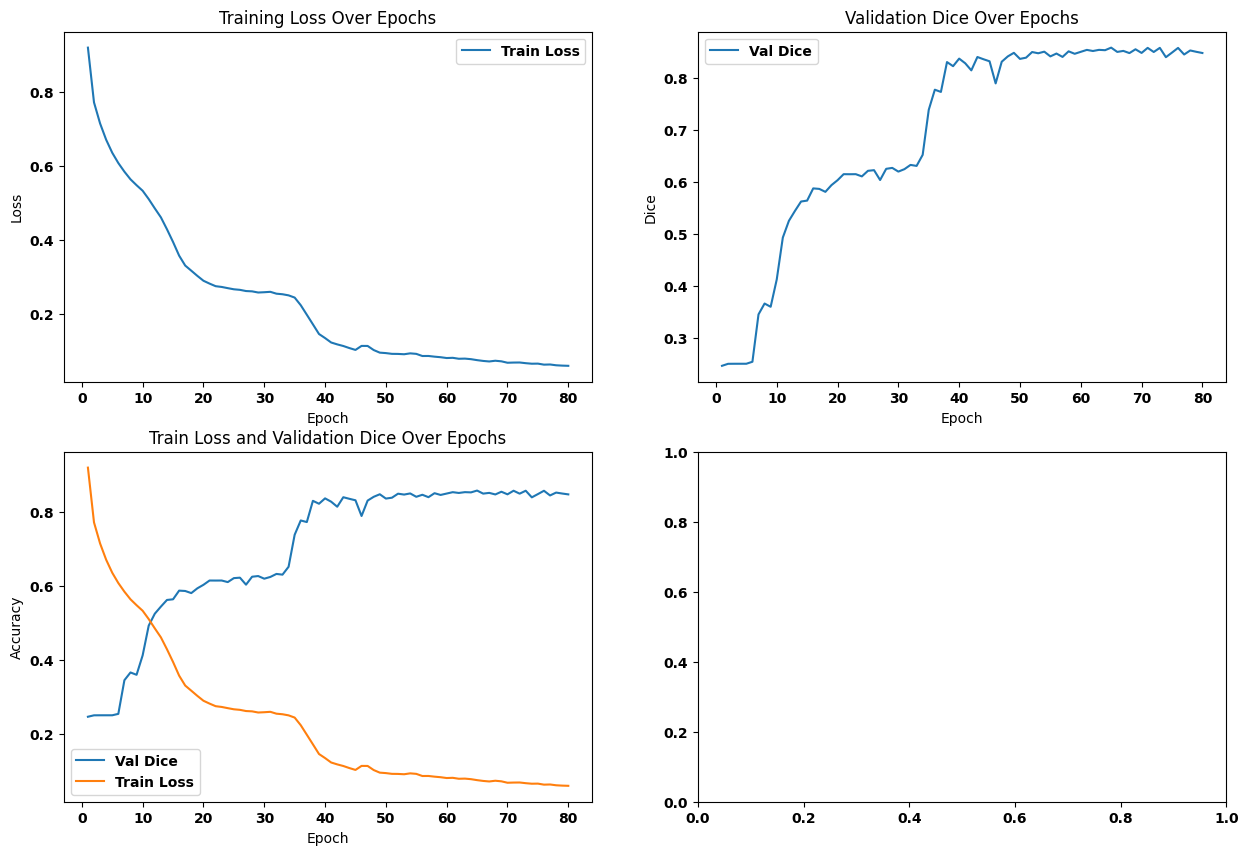

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0 ,0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training Loss Over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epoch_list, val_dice_list, label="Val Dice")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Dice")
axs[0, 1].set_title("Validation Dice Over Epochs")
axs[0, 1].legend()

"""
axs[1, 0].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Training Accuracy Over Epochs")
axs[1, 0].legend()
"""

axs[1, 0].plot(epoch_list, val_dice_list, label="Val Dice")
axs[1, 0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Train Loss and Validation Dice Over Epochs")
axs[1, 0].legend()

plt.show()

In [ ]:

df = pd.DataFrame({'Max_Epoch': epoch,
                     "Epoch_list": epoch_list,
                     "Validation_List": val_dice_list,
                     "HD95_List": hd95_list,
                     "ASD_List": asd_list,
                     "Train_Loss_List": train_loss_list,
                     "Best_Dice": best_metric,
                     "Best_Dice_Epoch": best_metric_epoch,
                    "Best_HD95": best_HD95,
                    "Best_ASD": best_ASD,
                    "Best_Metric_Epoch": best_metric_epoch})

file_path = "Train_Data_INFO/Cross_Validation/Kfold1_NoTuning_data_info.csv"

df.to_csv(file_path, index=False)
print(f"File saved to: {os.path.abspath(file_path)}")

File saved to: /content/drive/MyDrive/Train_Data_INFO/Cross_Validation/Kfold1_NoTuning_data_info.csv


##Model Evaluation

In [ ]:
# Model Evaluation
model.load_state_dict(torch.load(best_model_path))
model.eval()

def dice_score(pred, target, num_classes):
    """
    Calculate Dice score for each class and the combined hippocampus structure.
    """
    dice_scores = torch.zeros(num_classes, device=pred.device)

    for class_idx in range(num_classes):
        pred_mask = (pred == class_idx).float()
        target_mask = (target == class_idx).float()

        intersection = (pred_mask * target_mask).sum()
        pred_volume = pred_mask.sum()
        target_volume = target_mask.sum()

        if pred_volume + target_volume == 0:
            dice_scores[class_idx] = 1.0
        else:
            dice_scores[class_idx] = (2 * intersection) / (pred_volume + target_volume)

    hippocampus_classes = [1, 2, 3]
    pred_hippocampus = torch.zeros_like(pred, device=pred.device)
    target_hippocampus = torch.zeros_like(target, device=target.device)

    for class_idx in hippocampus_classes:
        pred_hippocampus = pred_hippocampus + (pred == class_idx).float()
        target_hippocampus = target_hippocampus + (target == class_idx).float()

    pred_hippocampus = (pred_hippocampus > 0).float()
    target_hippocampus = (target_hippocampus > 0).float()

    intersection = (pred_hippocampus * target_hippocampus).sum()
    pred_volume = pred_hippocampus.sum()
    target_volume = target_hippocampus.sum()

    if pred_volume + target_volume == 0:
        hippocampus_dice = 1.0
    else:
        hippocampus_dice = (2 * intersection) / (pred_volume + target_volume)

    return dice_scores, hippocampus_dice

# Validation with Dice, HD95, and ASD
test_dice_list = []
test_hd95_list = []
test_asd_list = []
class_dice = {'hippocampus': [], 'CA1': [], 'CA4DG': [], 'subiculum': []}
class_hd95 = {'hippocampus': [], 'CA1': [], 'CA4DG': [], 'subiculum': []}
class_asd = {'hippocampus': [], 'CA1': [], 'CA4DG': [], 'subiculum': []}

to_onehot = AsDiscrete(to_onehot=num_classes)

with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)

        # Convert logits to one-hot format
        val_outputs_post = [post_trans(i) for i in decollate_batch(val_outputs)]
        val_labels_onehot = [to_onehot(i) for i in decollate_batch(val_labels)]

        # Convert to class indices for Dice score computation
        val_outputs_indices = torch.argmax(val_outputs, dim=1)

        # Calculate Dice scores
        dice_scores, hippocampus_dice = dice_score(val_outputs_indices, val_labels, num_classes=4)
        class_dice['hippocampus'].append(hippocampus_dice.item())
        class_dice['CA1'].append(dice_scores[1].item())
        class_dice['CA4DG'].append(dice_scores[2].item())
        class_dice['subiculum'].append(dice_scores[3].item())
        test_dice_list.append(dice_scores.mean().item())

        # Compute overall HD95 and ASD
        hd95_metric(y_pred=val_outputs_post, y=val_labels_onehot)
        asd_metric(y_pred=val_outputs_post, y=val_labels_onehot)
        test_hd95_list.append(hd95_metric.aggregate().item())
        test_asd_list.append(asd_metric.aggregate().item())
        hd95_metric.reset()
        asd_metric.reset()

        # Compute per-class HD95 and ASD
        for class_idx in [1, 2, 3]:
            pred_mask = (val_outputs_indices == class_idx).float()  # Shape: [1, 160, 160, 160]
            target_mask = (val_labels == class_idx).float()        # Shape: [1, 160, 160, 160]
            # Convert to one-hot format: [num_classes, 160, 160, 160]
            pred_onehot = torch.zeros((num_classes, 160, 160, 160), device=pred_mask.device)
            target_onehot = torch.zeros((num_classes, 160, 160, 160), device=target_mask.device)
            for i in range(num_classes):
                pred_onehot[i] = (pred_mask == i).float().squeeze(0)  # Squeeze batch dim
                target_onehot[i] = (target_mask == i).float().squeeze(0)  # Squeeze batch dim
            hd95_metric(y_pred=[pred_onehot], y=[target_onehot])
            asd_metric(y_pred=[pred_onehot], y=[target_onehot])
            class_hd95[['CA1', 'CA4DG', 'subiculum'][class_idx-1]].append(hd95_metric.aggregate().item())
            class_asd[['CA1', 'CA4DG', 'subiculum'][class_idx-1]].append(asd_metric.aggregate().item())
            hd95_metric.reset()
            asd_metric.reset()

        # Compute hippocampus combined HD95 and ASD
        hippocampus_classes = [1, 2, 3]
        pred_hippocampus = torch.zeros_like(val_outputs_indices, device=val_outputs_indices.device)
        target_hippocampus = torch.zeros_like(val_labels, device=val_labels.device)
        for class_idx in hippocampus_classes:
            pred_hippocampus = pred_hippocampus + (val_outputs_indices == class_idx).float()
            target_hippocampus = target_hippocampus + (val_labels == class_idx).float()
        pred_hippocampus = (pred_hippocampus > 0).float()  # Shape: [1, 160, 160, 160]
        target_hippocampus = (target_hippocampus > 0).float()  # Shape: [1, 160, 160, 160]
        # Convert to one-hot format for binary (background vs. hippocampus): [2, 160, 160, 160]
        pred_hippocampus_onehot = torch.zeros((2, 160, 160, 160), device=pred_hippocampus.device)
        target_hippocampus_onehot = torch.zeros((2, 160, 160, 160), device=target_hippocampus.device)
        pred_hippocampus_onehot[0] = (pred_hippocampus == 0).float().squeeze(0)
        pred_hippocampus_onehot[1] = pred_hippocampus.squeeze(0)
        target_hippocampus_onehot[0] = (target_hippocampus == 0).float().squeeze(0)
        target_hippocampus_onehot[1] = target_hippocampus.squeeze(0)
        hd95_metric(y_pred=[pred_hippocampus_onehot], y=[target_hippocampus_onehot])
        asd_metric(y_pred=[pred_hippocampus_onehot], y=[target_hippocampus_onehot])
        class_hd95['hippocampus'].append(hd95_metric.aggregate().item())
        class_asd['hippocampus'].append(asd_metric.aggregate().item())
        hd95_metric.reset()
        asd_metric.reset()

        print(f"Validation - Mean Dice: {test_dice_list[-1]:.4f}, HD95: {test_hd95_list[-1]:.4f}, ASD: {test_asd_list[-1]:.4f}")
        print(f"Hippocampus: Dice: {class_dice['hippocampus'][-1]:.4f}, HD95: {class_hd95['hippocampus'][-1]:.4f}, ASD: {class_asd['hippocampus'][-1]:.4f}")
        print(f"CA1: Dice: {class_dice['CA1'][-1]:.4f}, HD95: {class_hd95['CA1'][-1]:.4f}, ASD: {class_asd['CA1'][-1]:.4f}")
        print(f"CA4DG: Dice: {class_dice['CA4DG'][-1]:.4f}, HD95: {class_hd95['CA4DG'][-1]:.4f}, ASD: {class_asd['CA4DG'][-1]:.4f}")
        print(f"Subiculum: Dice: {class_dice['subiculum'][-1]:.4f}, HD95: {class_hd95['subiculum'][-1]:.4f}, ASD: {class_asd['subiculum'][-1]:.4f}")

# Calculate final statistics
def get_stats(values):
    return np.mean(values), np.std(values)

overall_dice_mean, overall_dice_std = get_stats(test_dice_list)
hippocampus_dice_mean, hippocampus_dice_std = get_stats(class_dice['hippocampus'])
ca1_dice_mean, ca1_dice_std = get_stats(class_dice['CA1'])
ca4dg_dice_mean, ca4dg_dice_std = get_stats(class_dice['CA4DG'])
sub_dice_mean, sub_dice_std = get_stats(class_dice['subiculum'])

overall_hd95_mean, overall_hd95_std = get_stats(test_hd95_list)
hippocampus_hd95_mean, hippocampus_hd95_std = get_stats(class_hd95['hippocampus'])
ca1_hd95_mean, ca1_hd95_std = get_stats(class_hd95['CA1'])
ca4dg_hd95_mean, ca4dg_hd95_std = get_stats(class_hd95['CA4DG'])
sub_hd95_mean, sub_hd95_std = get_stats(class_hd95['subiculum'])

overall_asd_mean, overall_asd_std = get_stats(test_asd_list)
hippocampus_asd_mean, hippocampus_asd_std = get_stats(class_asd['hippocampus'])
ca1_asd_mean, ca1_asd_std = get_stats(class_asd['CA1'])
ca4dg_asd_mean, ca4dg_asd_std = get_stats(class_asd['CA4DG'])
sub_asd_mean, sub_asd_std = get_stats(class_asd['subiculum'])

print("\nFinal Test Metrics:")
print(f"Overall: Dice: {overall_dice_mean:.4f} ± {overall_dice_std:.4f}, HD95: {overall_hd95_mean:.4f} ± {overall_hd95_std:.4f}, ASD: {overall_asd_mean:.4f} ± {overall_asd_std:.4f}")
print(f"Hippocampus: Dice: {hippocampus_dice_mean:.4f} ± {hippocampus_dice_std:.4f}, HD95: {hippocampus_hd95_mean:.4f} ± {hippocampus_hd95_std:.4f}, ASD: {hippocampus_asd_mean:.4f} ± {hippocampus_asd_std:.4f}")
print(f"CA1: Dice: {ca1_dice_mean:.4f} ± {ca1_dice_std:.4f}, HD95: {ca1_hd95_mean:.4f} ± {ca1_hd95_std:.4f}, ASD: {ca1_asd_mean:.4f} ± {ca1_asd_std:.4f}")
print(f"CA4DG: Dice: {ca4dg_dice_mean:.4f} ± {ca4dg_dice_std:.4f}, HD95: {ca4dg_hd95_mean:.4f} ± {ca4dg_hd95_std:.4f}, ASD: {ca4dg_asd_mean:.4f} ± {ca4dg_asd_std:.4f}")
print(f"Subiculum: Dice: {sub_dice_mean:.4f} ± {sub_dice_std:.4f}, HD95: {sub_hd95_mean:.4f} ± {sub_hd95_std:.4f}, ASD: {sub_asd_mean:.4f} ± {sub_asd_std:.4f}")

/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:330: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:330: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(


Validation - Mean Dice: 0.8416, HD95: 2.4714, ASD: 0.6107
Hippocampus: Dice: 0.8988, HD95: 1.4142, ASD: 0.4921
CA1: Dice: 0.8315, HD95: 1.4142, ASD: 0.5069
CA4DG: Dice: 0.7606, HD95: 2.0000, ASD: 0.5379
Subiculum: Dice: 0.7744, HD95: 4.0000, ASD: 0.7874
Validation - Mean Dice: 0.8333, HD95: 1.8834, ASD: 0.4494
Hippocampus: Dice: 0.8750, HD95: 2.0000, ASD: 0.4600
CA1: Dice: 0.7991, HD95: 1.4142, ASD: 0.4877
CA4DG: Dice: 0.7453, HD95: 2.2361, ASD: 0.4631
Subiculum: Dice: 0.7889, HD95: 2.0000, ASD: 0.3974
Validation - Mean Dice: 0.8577, HD95: 1.6191, ASD: 0.3918
Hippocampus: Dice: 0.9026, HD95: 1.4142, ASD: 0.3807
CA1: Dice: 0.8406, HD95: 1.2071, ASD: 0.4151
CA4DG: Dice: 0.7816, HD95: 1.4142, ASD: 0.3729
Subiculum: Dice: 0.8089, HD95: 2.2361, ASD: 0.3874
Validation - Mean Dice: 0.8685, HD95: 1.1381, ASD: 0.3483
Hippocampus: Dice: 0.9178, HD95: 1.4142, ASD: 0.3352
CA1: Dice: 0.8556, HD95: 1.0000, ASD: 0.3668
CA4DG: Dice: 0.8207, HD95: 1.0000, ASD: 0.3580
Subiculum: Dice: 0.7978, HD95: 1.41

In [ ]:
metrics_dict = {
    'Region': ['Overall', 'Hippocampus', 'CA1', 'CA4DG', 'Subiculum'],
    'Dice_Mean': [overall_dice_mean, hippocampus_dice_mean, ca1_dice_mean, ca4dg_dice_mean, sub_dice_mean],
    'Dice_Std': [overall_dice_std, hippocampus_dice_std, ca1_dice_std, ca4dg_dice_std, sub_dice_std],
    'HD95_Mean': [overall_hd95_mean, hippocampus_hd95_mean, ca1_hd95_mean, ca4dg_hd95_mean, sub_hd95_mean],
    'HD95_Std': [overall_hd95_std, hippocampus_hd95_std, ca1_hd95_std, ca4dg_hd95_std, sub_hd95_std],
    'ASD_Mean': [overall_asd_mean, hippocampus_asd_mean, ca1_asd_mean, ca4dg_asd_mean, sub_asd_mean],
    'ASD_Std': [overall_asd_std, hippocampus_asd_std, ca1_asd_std, ca4dg_asd_std, sub_asd_std]
}

metrics_df = pd.DataFrame(metrics_dict)

metrics_file_path = "Train_Data_INFO/Cross_Validation/Fold1_NoTuning_test_metrics.csv"

metrics_df.to_csv(metrics_file_path, index=False)
print(f"Final test metrics saved to: {os.path.abspath(metrics_file_path)}")

Final test metrics saved to: /content/drive/MyDrive/Train_Data_INFO/Cross_Validation/Fold1_NoTuning_test_metrics.csv


In [ ]:
model.eval()
test_dice_list = []
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred=val_outputs, y=val_labels)

        dice_mean = dice_metric.aggregate().item()
        test_dice_list.append(dice_mean)
        dice_metric.reset()
        print(f"Validation Dice: {dice_mean:.4f}")

test_dice_mean = np.mean(test_dice_list)
std_dev = np.std(test_dice_list)
print(f"\nTest Dice: {test_dice_mean:.4f}, Std Dev: {std_dev:.4f}")

Validation Dice: 0.8342
Validation Dice: 0.8146
Validation Dice: 0.8180
Validation Dice: 0.8399
Validation Dice: 0.8590

Test Dice: 0.8332, Std Dev: 0.0161


In [ ]:
# Load the model
#load_model(model, '/content/drive/MyDrive/Checkpoints/150_epoch_1e-2_best_model.pth')
model.eval()
# Get validation data
val_img, val_seg = val_ds[0]
val_img_ = val_img.unsqueeze(0).cuda()

# Generate prediction
with torch.no_grad():
    pred_logits = model(val_img_)
    # Apply softmax to get probabilities
    pred_probs = torch.softmax(pred_logits, dim=1)
    # Get the class with highest probability
    pred_label = torch.argmax(pred_probs, dim=1, keepdim=True)  # shape [1,1,D,H,W]

# Convert to numpy for visualization
pred_label_np = pred_label.squeeze().cpu().numpy()  # shape [D,H,W]
val_img_np = val_img.squeeze().numpy()              # shape [D,H,W]
val_seg_np = val_seg.squeeze().numpy()              # ground truth

print("Predicted label map shape:", pred_label_np.shape)

Predicted label map shape: (160, 160, 160)


In [ ]:
print(np.unique(pred_label_np), len(np.unique(pred_label_np)))

[0 1 2 3] 4


###Changing contiguous labels to standard labels

In [ ]:
STD_LABEL_VALUES = np.array([0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28, 30, 31, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60, 62, 63, 77, 80, 85, 251, 252, 253, 254, 255])

In [ ]:
std_pred_label = STD_LABEL_VALUES[pred_label_np]
std_val_seg = STD_LABEL_VALUES[val_seg_np.astype('int')]

In [ ]:
np.unique(std_pred_label)

array([0, 2, 3, 4])

###Visualization of Predicted and Ground Truth Labels

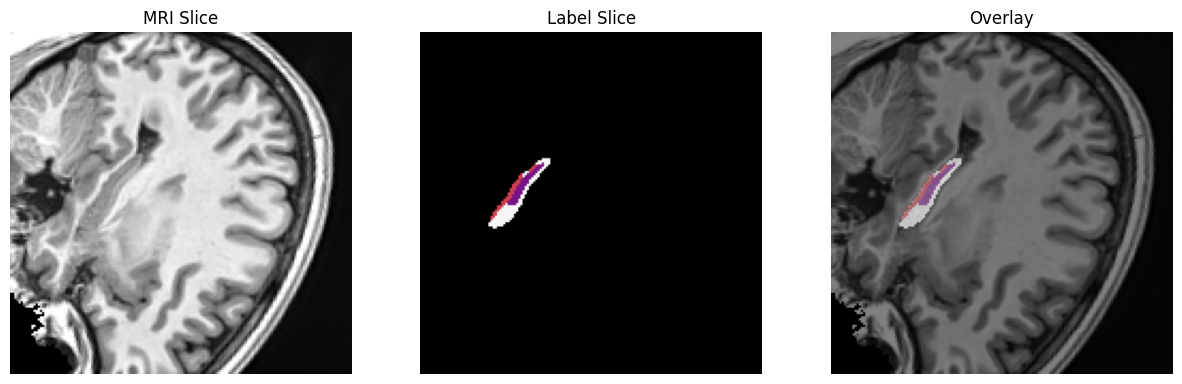

In [ ]:
#Prediction
visualize_image(val_img_np,std_pred_label, 50, array = True)

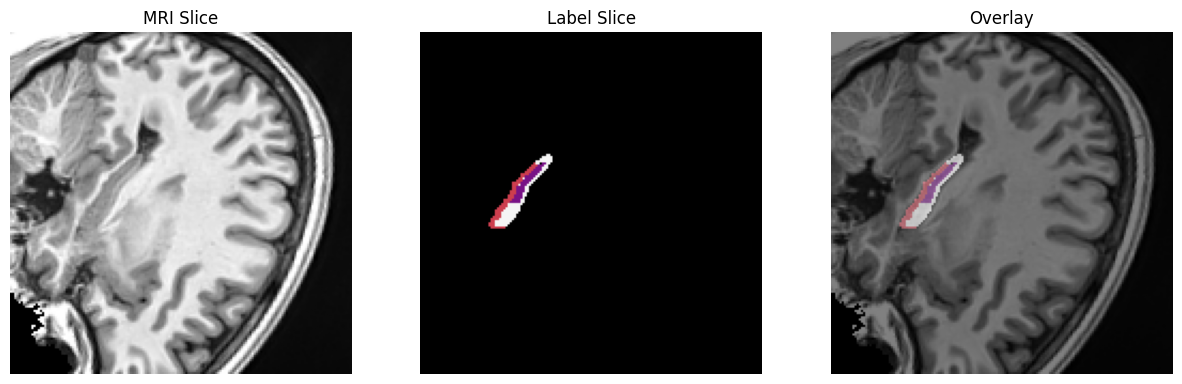

In [ ]:
#Ground Truth
visualize_image(val_img_np, std_val_seg, 50, array = True)